# Session 9: Ensemble Methods

## Overview
Ensemble methods combine multiple machine learning models to create a stronger predictor than any of the individual models alone. The key idea is that by combining multiple models, we can reduce overfitting, improve generalization, and achieve better performance.

### Topics Covered:
1. **Introduction to Ensemble Methods**
2. **Bagging Methods (Random Forest)**
3. **Boosting Methods (AdaBoost, Gradient Boosting, XGBoost)**
4. **Comparing Ensembles with Single Models**
5. **Practical Implementation and Evaluation**

### Learning Objectives:
- Understand the principles behind ensemble methods
- Learn about bagging and boosting techniques
- Implement Random Forest, AdaBoost, Gradient Boosting, and XGBoost
- Compare ensemble methods with single models
- Apply ensemble methods to real-world datasets

## 1. Introduction to Ensemble Methods

### What are Ensemble Methods?
Ensemble methods combine predictions from multiple models to make a final prediction. The main types are:

1. **Bagging (Bootstrap Aggregating)**: Training multiple models on different subsets of the training data
2. **Boosting**: Training models sequentially, where each model learns from the mistakes of previous models
3. **Stacking**: Using a meta-model to combine predictions from multiple base models

### Why Use Ensemble Methods?
- **Reduced Overfitting**: Combining multiple models reduces variance
- **Improved Accuracy**: Often outperform individual models
- **Robustness**: Less sensitive to outliers and noise
- **Bias-Variance Trade-off**: Can reduce both bias and variance

In [38]:
!pip install xgboost
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

# Individual Models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC

# Ensemble Methods
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    AdaBoostClassifier, AdaBoostRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    BaggingClassifier, BaggingRegressor,
    VotingClassifier, VotingRegressor
)

# For XGBoost (may need installation)
try:
    import xgboost as xgb
    print("XGBoost is available")
except ImportError:
    print("XGBoost not installed. You can install it using: pip install xgboost")

# Dataset
from sklearn.datasets import load_wine, make_classification, fetch_california_housing

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

XGBoost is available
All libraries imported successfully!


## 2. Bagging Methods - Random Forest

### What is Bagging?
Bagging (Bootstrap Aggregating) creates multiple subsets of the training data through bootstrap sampling, trains a model on each subset, and then combines their predictions.

### Random Forest
Random Forest is an extension of bagging that:
1. Uses decision trees as base learners
2. Introduces randomness in feature selection at each split
3. Combines predictions through majority voting (classification) or averaging (regression)

### Advantages:
- Reduces overfitting compared to individual decision trees
- Handles missing values well
- Provides feature importance
- Works well with both numerical and categorical features

In [39]:
# Load and prepare the Wine dataset for classification
wine_data = load_wine()
X_wine = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
y_wine = wine_data.target

print("Wine Dataset Shape:", X_wine.shape)
print("Target Classes:", np.unique(y_wine))
print("\nFirst few rows:")
print(X_wine.head())

Wine Dataset Shape: (178, 13)
Target Classes: [0 1 2]

First few rows:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  

In [40]:
# Split the data
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    X_wine, y_wine, test_size=0.3, random_state=42, stratify=y_wine
)

print(f"Training set size: {X_train_wine.shape[0]}")
print(f"Test set size: {X_test_wine.shape[0]}")

Training set size: 124
Test set size: 54


In [41]:
# Compare Single Decision Tree vs Random Forest

# Single Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_wine, y_train_wine)
dt_pred = dt_classifier.predict(X_test_wine)
dt_accuracy = accuracy_score(y_test_wine, dt_pred)

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_wine, y_train_wine)
rf_pred = rf_classifier.predict(X_test_wine)
rf_accuracy = accuracy_score(y_test_wine, rf_pred)

print("Model Performance Comparison:")
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Improvement: {rf_accuracy - dt_accuracy:.4f}")

Model Performance Comparison:
Decision Tree Accuracy: 0.9630
Random Forest Accuracy: 1.0000
Improvement: 0.0370


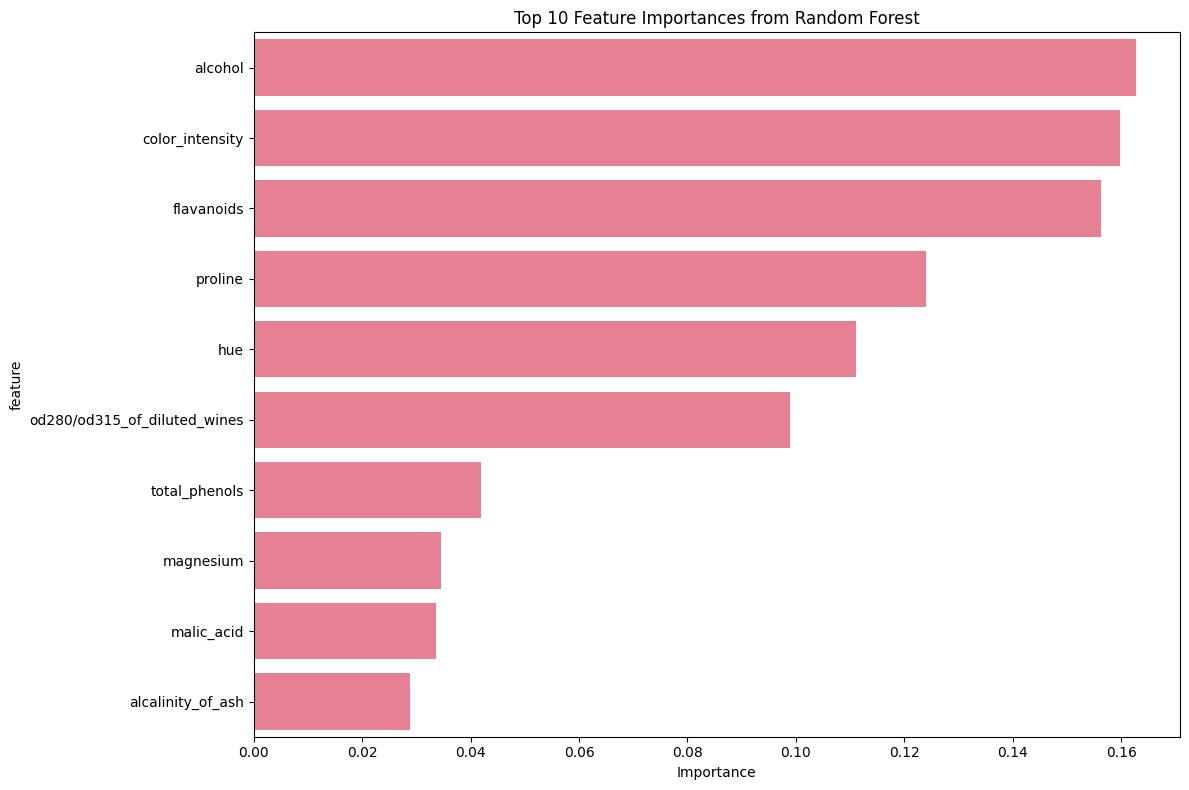

Top 5 Most Important Features:
            feature  importance
0           alcohol    0.162715
9   color_intensity    0.159719
6        flavanoids    0.156283
12          proline    0.124081
10              hue    0.111019


In [42]:
# Feature Importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X_wine.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 5 Most Important Features:")
print(feature_importance.head())

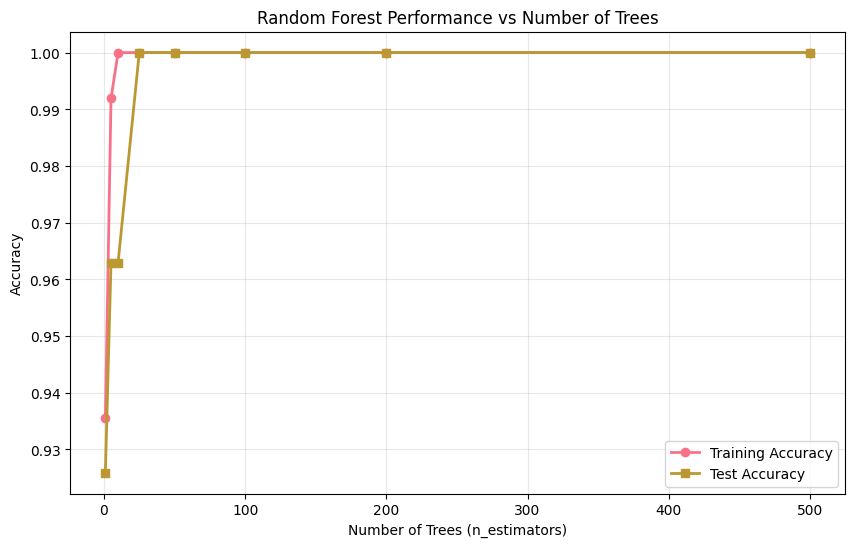

In [43]:
# Effect of Number of Trees on Performance
n_estimators_range = [1, 5, 10, 25, 50, 100, 200, 500]
train_scores = []
test_scores = []

for n_est in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_est, random_state=42)
    rf.fit(X_train_wine, y_train_wine)
    
    train_score = rf.score(X_train_wine, y_train_wine)
    test_score = rf.score(X_test_wine, y_test_wine)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, 'o-', label='Training Accuracy', linewidth=2)
plt.plot(n_estimators_range, test_scores, 's-', label='Test Accuracy', linewidth=2)
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance vs Number of Trees')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Boosting Methods

### What is Boosting?
Boosting trains models sequentially, where each subsequent model focuses on correcting the errors made by previous models.

### Types of Boosting:
1. **AdaBoost (Adaptive Boosting)**: Adjusts weights of misclassified instances
2. **Gradient Boosting**: Uses gradient descent to minimize loss function
3. **XGBoost**: Optimized gradient boosting with regularization

### 3.1 AdaBoost (Adaptive Boosting)

In [44]:
# AdaBoost Classifier
ada_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # Weak learners
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

ada_classifier.fit(X_train_wine, y_train_wine)
ada_pred = ada_classifier.predict(X_test_wine)
ada_accuracy = accuracy_score(y_test_wine, ada_pred)

print(f"AdaBoost Accuracy: {ada_accuracy:.4f}")

# Compare with single weak learner
weak_learner = DecisionTreeClassifier(max_depth=1, random_state=42)
weak_learner.fit(X_train_wine, y_train_wine)
weak_pred = weak_learner.predict(X_test_wine)
weak_accuracy = accuracy_score(y_test_wine, weak_pred)

print(f"Single Weak Learner Accuracy: {weak_accuracy:.4f}")
print(f"AdaBoost Improvement: {ada_accuracy - weak_accuracy:.4f}")

AdaBoost Accuracy: 0.9815
Single Weak Learner Accuracy: 0.6111
AdaBoost Improvement: 0.3704


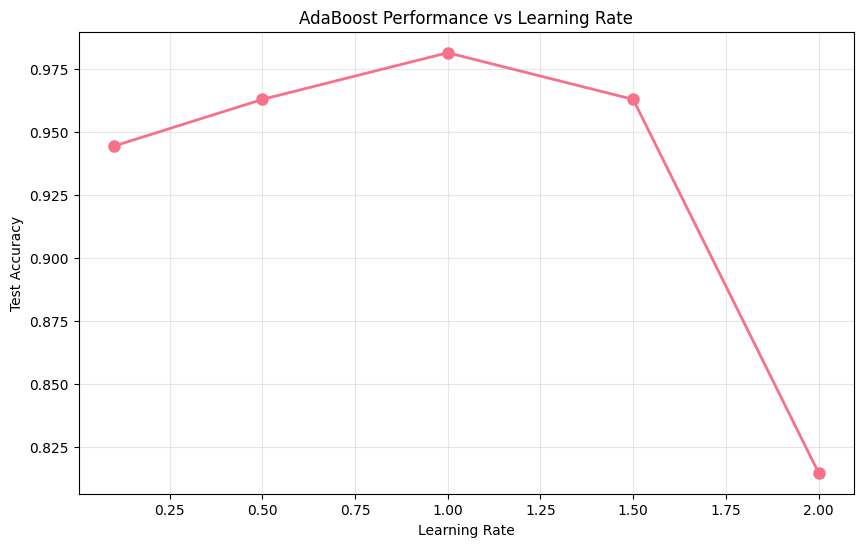

Best Learning Rate: 1.0
Best Accuracy: 0.9815


In [45]:
# Effect of Learning Rate on AdaBoost
learning_rates = [0.1, 0.5, 1.0, 1.5, 2.0]
ada_scores = []

for lr in learning_rates:
    ada = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=100,
        learning_rate=lr,
        random_state=42
    )
    ada.fit(X_train_wine, y_train_wine)
    score = ada.score(X_test_wine, y_test_wine)
    ada_scores.append(score)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, ada_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('AdaBoost Performance vs Learning Rate')
plt.grid(True, alpha=0.3)
plt.show()

best_lr = learning_rates[np.argmax(ada_scores)]
print(f"Best Learning Rate: {best_lr}")
print(f"Best Accuracy: {max(ada_scores):.4f}")

### 3.2 Gradient Boosting

In [46]:
# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_classifier.fit(X_train_wine, y_train_wine)
gb_pred = gb_classifier.predict(X_test_wine)
gb_accuracy = accuracy_score(y_test_wine, gb_pred)

print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")

# Feature importance
gb_importance = pd.DataFrame({
    'feature': X_wine.columns,
    'importance': gb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Features (Gradient Boosting):")
print(gb_importance.head())

Gradient Boosting Accuracy: 0.9630

Top 5 Features (Gradient Boosting):
                         feature  importance
9                color_intensity    0.286952
12                       proline    0.258557
11  od280/od315_of_diluted_wines    0.188589
6                     flavanoids    0.119016
1                     malic_acid    0.054765


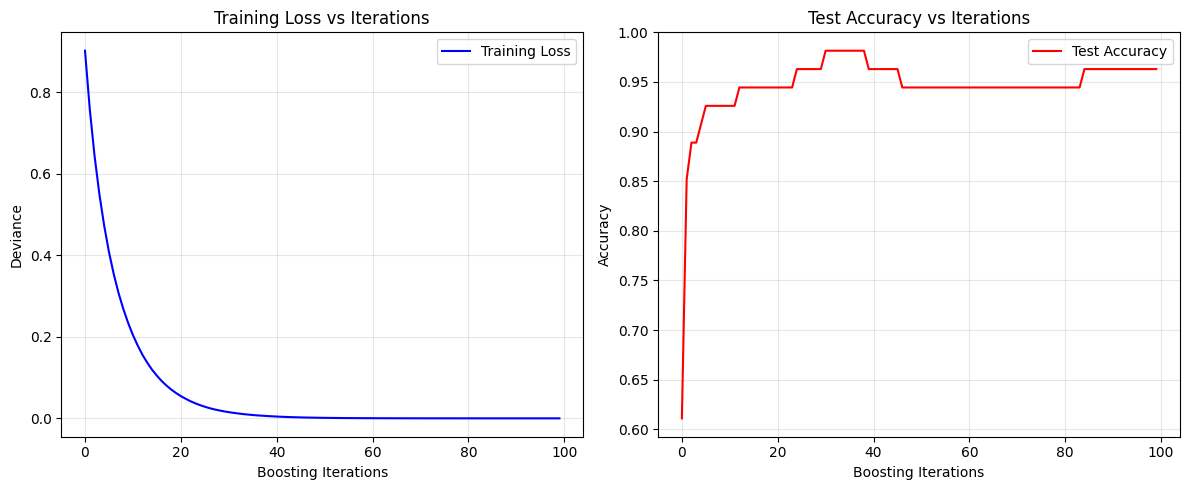

In [47]:
# Training Progress Visualization
# Plot training deviance
test_score = np.zeros((gb_classifier.n_estimators,), dtype=np.float64)

for i, y_pred in enumerate(gb_classifier.staged_predict(X_test_wine)):
    test_score[i] = accuracy_score(y_test_wine, y_pred)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gb_classifier.train_score_, 'b-', label='Training Loss')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.title('Training Loss vs Iterations')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(test_score, 'r-', label='Test Accuracy')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Iterations')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 XGBoost (if available)

In [48]:
# XGBoost Classifier (if available)
try:
    xgb_classifier = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    
    xgb_classifier.fit(X_train_wine, y_train_wine)
    xgb_pred = xgb_classifier.predict(X_test_wine)
    xgb_accuracy = accuracy_score(y_test_wine, xgb_pred)
    
    print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
    
    # Feature importance
    xgb_importance = pd.DataFrame({
        'feature': X_wine.columns,
        'importance': xgb_classifier.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 5 Features (XGBoost):")
    print(xgb_importance.head())
    
except NameError:
    print("XGBoost not available. Install it using: pip install xgboost")
    xgb_accuracy = None

XGBoost Accuracy: 1.0000

Top 5 Features (XGBoost):
                         feature  importance
11  od280/od315_of_diluted_wines    0.419950
9                color_intensity    0.148428
12                       proline    0.125089
6                     flavanoids    0.111899
1                     malic_acid    0.043359


## 4. Comprehensive Model Comparison

In [49]:
# Compare all models
models = {
    'Decision Tree': dt_classifier,
    'Random Forest': rf_classifier,
    'AdaBoost': ada_classifier,
    'Gradient Boosting': gb_classifier
}

# Add XGBoost if available
if 'xgb_classifier' in locals():
    models['XGBoost'] = xgb_classifier

# Cross-validation scores
cv_results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_wine, y_train_wine, cv=5, scoring='accuracy')
    cv_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'CV Mean Accuracy': [cv_results[name]['mean'] for name in cv_results.keys()],
    'CV Std': [cv_results[name]['std'] for name in cv_results.keys()]
})

print("Cross-Validation Results:")
print(comparison_df.round(4))

Cross-Validation Results:
               Model  CV Mean Accuracy  CV Std
0      Decision Tree            0.8620  0.0682
1      Random Forest            0.9673  0.0310
2           AdaBoost            0.9430  0.0424
3  Gradient Boosting            0.8863  0.0613
4            XGBoost            0.9513  0.0307


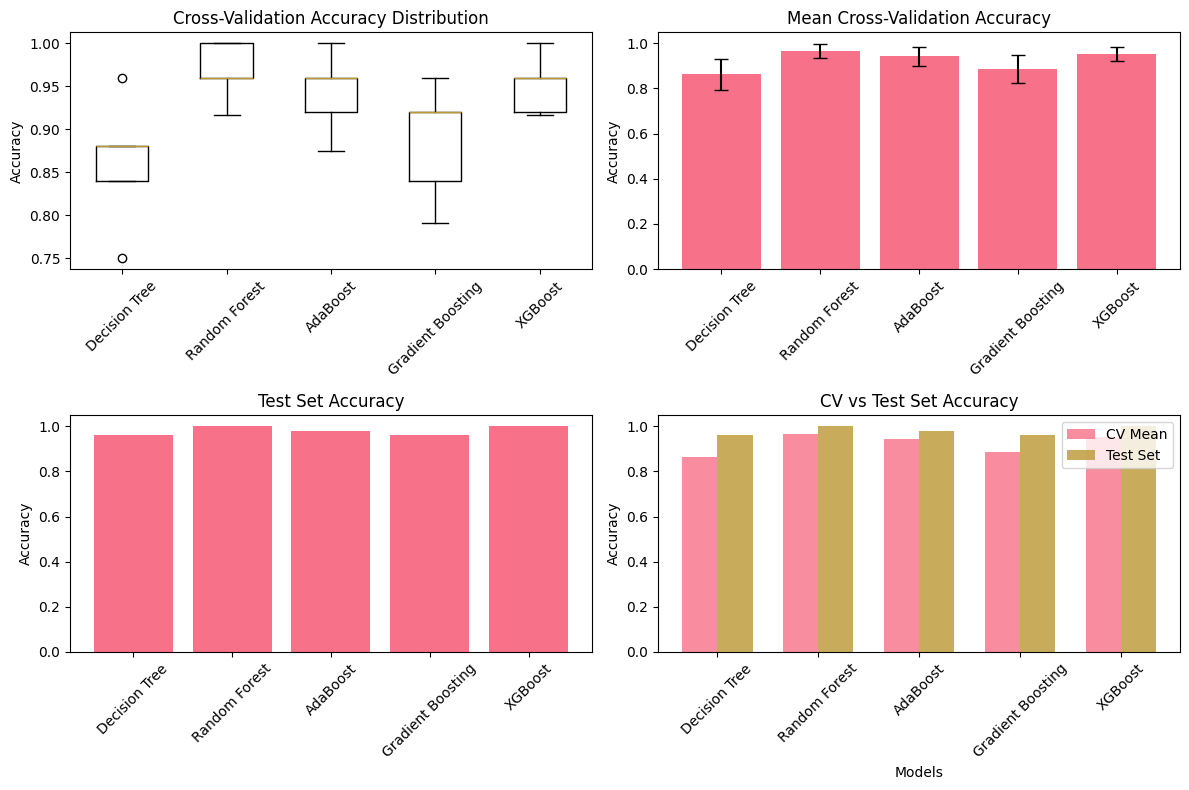

In [50]:
# Visualize model comparison
plt.figure(figsize=(12, 8))

# Box plot of CV scores
plt.subplot(2, 2, 1)
cv_data = [cv_results[name]['scores'] for name in cv_results.keys()]
plt.boxplot(cv_data, labels=list(cv_results.keys()))
plt.title('Cross-Validation Accuracy Distribution')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Bar plot of mean accuracies
plt.subplot(2, 2, 2)
plt.bar(comparison_df['Model'], comparison_df['CV Mean Accuracy'], 
        yerr=comparison_df['CV Std'], capsize=5)
plt.title('Mean Cross-Validation Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Test set accuracies
test_accuracies = {
    'Decision Tree': dt_accuracy,
    'Random Forest': rf_accuracy,
    'AdaBoost': ada_accuracy,
    'Gradient Boosting': gb_accuracy
}

if xgb_accuracy is not None:
    test_accuracies['XGBoost'] = xgb_accuracy

plt.subplot(2, 2, 3)
plt.bar(test_accuracies.keys(), test_accuracies.values())
plt.title('Test Set Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Combined comparison
plt.subplot(2, 2, 4)
x = np.arange(len(comparison_df))
width = 0.35

plt.bar(x - width/2, comparison_df['CV Mean Accuracy'], width, 
        label='CV Mean', alpha=0.8)
plt.bar(x + width/2, list(test_accuracies.values()), width, 
        label='Test Set', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('CV vs Test Set Accuracy')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

## 5. Voting Ensemble

In [51]:
# Create a Voting Classifier
# Combine the best individual models
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('ada', AdaBoostClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ],
    voting='hard'  # Use 'soft' for probability-based voting
)

voting_clf.fit(X_train_wine, y_train_wine)
voting_pred = voting_clf.predict(X_test_wine)
voting_accuracy = accuracy_score(y_test_wine, voting_pred)

print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

# Compare with individual models
print("\nComparison with Individual Models:")
print(f"Random Forest: {rf_accuracy:.4f}")
print(f"AdaBoost: {ada_accuracy:.4f}")
print(f"Gradient Boosting: {gb_accuracy:.4f}")
print(f"Voting Ensemble: {voting_accuracy:.4f}")

Voting Classifier Accuracy: 1.0000

Comparison with Individual Models:
Random Forest: 1.0000
AdaBoost: 0.9815
Gradient Boosting: 0.9630
Voting Ensemble: 1.0000


## 6. Regression Example with Ensemble Methods

In [52]:
# Create a regression dataset
from sklearn.datasets import make_regression

X_reg, y_reg = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

print(f"Regression dataset shape: {X_reg.shape}")
print(f"Target range: [{y_reg.min():.2f}, {y_reg.max():.2f}]")

Regression dataset shape: (1000, 10)
Target range: [-449.01, 411.14]


In [53]:
# Compare regression models
reg_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

reg_results = {}
for name, model in reg_models.items():
    model.fit(X_train_reg, y_train_reg)
    pred = model.predict(X_test_reg)
    
    mse = mean_squared_error(y_test_reg, pred)
    r2 = r2_score(y_test_reg, pred)
    
    reg_results[name] = {'MSE': mse, 'R2': r2}

# Display results
reg_df = pd.DataFrame(reg_results).T
print("Regression Model Comparison:")
print(reg_df.round(4))

Regression Model Comparison:
                         MSE      R2
Linear Regression     0.0094  1.0000
Decision Tree      6551.7568  0.6465
Random Forest      2793.3610  0.8493
AdaBoost           3857.0280  0.7919
Gradient Boosting  1321.5928  0.9287


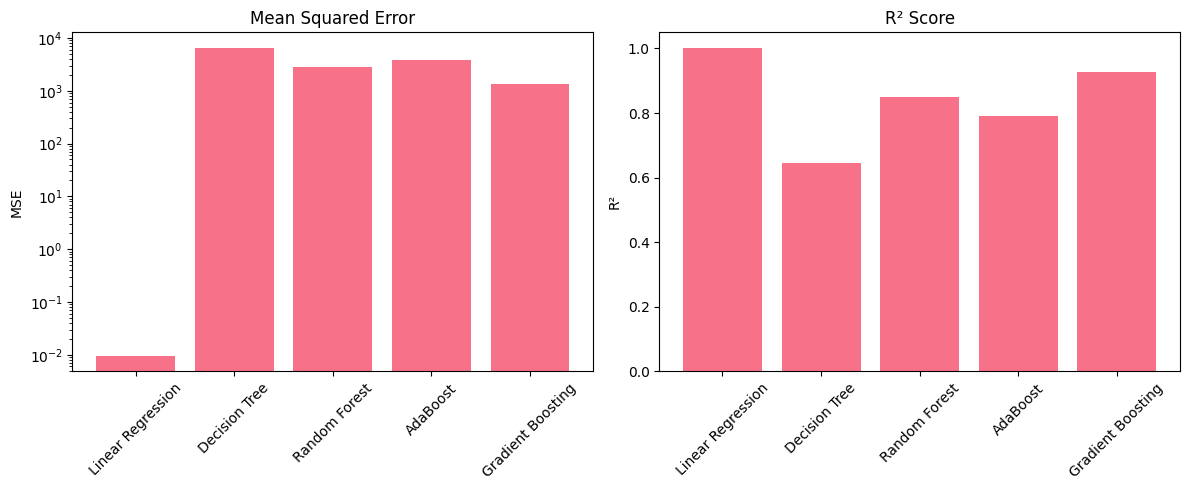

In [54]:
# Visualize regression results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(reg_df.index, reg_df['MSE'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.yscale('log')  # Log scale for better visualization

plt.subplot(1, 2, 2)
plt.bar(reg_df.index, reg_df['R2'])
plt.title('R² Score')
plt.ylabel('R²')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 7. Hyperparameter Tuning for Ensemble Methods

In [55]:
# Grid Search for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=3,  # Reduced for faster execution
    scoring='accuracy',
    n_jobs=-1
)

print("Performing Grid Search for Random Forest...")
rf_grid.fit(X_train_wine, y_train_wine)

print(f"Best Random Forest Parameters: {rf_grid.best_params_}")
print(f"Best CV Score: {rf_grid.best_score_:.4f}")

# Test the best model
best_rf = rf_grid.best_estimator_
best_rf_pred = best_rf.predict(X_test_wine)
best_rf_accuracy = accuracy_score(y_test_wine, best_rf_pred)
print(f"Best Random Forest Test Accuracy: {best_rf_accuracy:.4f}")

Performing Grid Search for Random Forest...
Best Random Forest Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score: 0.9758
Best Random Forest Test Accuracy: 1.0000
Best Random Forest Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score: 0.9758
Best Random Forest Test Accuracy: 1.0000


## 8. Practical Tips and Best Practices

### When to Use Each Method:

1. **Random Forest**:
   - Good general-purpose algorithm
   - Handles mixed data types well
   - Provides feature importance
   - Less prone to overfitting

2. **AdaBoost**:
   - Works well with weak learners
   - Good for binary classification
   - Sensitive to noise and outliers

3. **Gradient Boosting**:
   - Often achieves high accuracy
   - Requires careful tuning
   - Can overfit easily

4. **XGBoost**:
   - State-of-the-art performance
   - Built-in regularization
   - Handles missing values
   - Fast and efficient

### Key Parameters to Tune:
- **n_estimators**: Number of base models
- **learning_rate**: Step size for boosting methods
- **max_depth**: Maximum depth of trees
- **min_samples_split/leaf**: Minimum samples for splits/leaves
- **subsample**: Fraction of samples used for training 

In [56]:
# Final Model Recommendation
print("=== ENSEMBLE METHODS SUMMARY ===")
print("\nModel Performance on Wine Dataset:")
print(f"1. Decision Tree (baseline): {dt_accuracy:.4f}")
print(f"2. Random Forest: {rf_accuracy:.4f}")
print(f"3. AdaBoost: {ada_accuracy:.4f}")
print(f"4. Gradient Boosting: {gb_accuracy:.4f}")
if xgb_accuracy is not None:
    print(f"5. XGBoost: {xgb_accuracy:.4f}")
print(f"6. Voting Ensemble: {voting_accuracy:.4f}")
print(f"7. Tuned Random Forest: {best_rf_accuracy:.4f}")

# Find best model
all_scores = {
    'Decision Tree': dt_accuracy,
    'Random Forest': rf_accuracy,
    'AdaBoost': ada_accuracy,
    'Gradient Boosting': gb_accuracy,
    'Voting Ensemble': voting_accuracy,
    'Tuned Random Forest': best_rf_accuracy
}

if xgb_accuracy is not None:
    all_scores['XGBoost'] = xgb_accuracy

best_model = max(all_scores, key=all_scores.get)
best_score = all_scores[best_model]

print(f"\n🏆 Best Model: {best_model} (Accuracy: {best_score:.4f})")
print(f"\n📈 Improvement over baseline: {best_score - dt_accuracy:.4f}")

=== ENSEMBLE METHODS SUMMARY ===

Model Performance on Wine Dataset:
1. Decision Tree (baseline): 0.9630
2. Random Forest: 1.0000
3. AdaBoost: 0.9815
4. Gradient Boosting: 0.9630
5. XGBoost: 1.0000
6. Voting Ensemble: 1.0000
7. Tuned Random Forest: 1.0000

🏆 Best Model: Random Forest (Accuracy: 1.0000)

📈 Improvement over baseline: 0.0370


## 10. Key Takeaways

### What We Learned:
1. **Ensemble Methods** combine multiple models to achieve better performance
2. **Bagging** (Random Forest) reduces variance by training on different data subsets
3. **Boosting** (AdaBoost, Gradient Boosting, XGBoost) reduces bias by learning from mistakes
4. **Voting** combines predictions from different types of models
5. **Hyperparameter tuning** is crucial for optimal performance

### Best Practices:
- Start with Random Forest as a strong baseline
- Use cross-validation for model selection
- Tune hyperparameters systematically
- Consider computational cost vs. performance trade-offs
- Ensemble different types of models for best results

### Next Steps:
- Practice with different datasets
- Explore advanced ensemble techniques (Stacking, Blending)
- Learn about ensemble methods for specific domains
- Study competition-winning ensemble strategies